# FINAL for submission: Baseline model

## Set up: import libraries and read data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, precision_recall_curve,precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
sentiment = pd.read_csv('/content/drive/MyDrive/CS3244 Grp Project/Model training/sentiment.csv')
sentiment = sentiment.dropna()
X_train = sentiment.drop(columns = ['label', 'parent_comment'])
y_train = sentiment['label']

## Modelling

In [9]:


kf = KFold(n_splits = 5, shuffle = True, random_state = 123)
acc = []
prec = []
rec = []
f1 = []
y_pred = []
y_true = []

for train_i, val_i in kf.split(X_train):
  X_train_fold, X_val_fold = X_train.iloc[train_i], X_train.iloc[val_i] # numpy array
  y_train_fold, y_val_fold = y_train.iloc[train_i], y_train.iloc[val_i] # pd df

  # Apply Tf-idf vectors on comments
  tfidf = TfidfVectorizer(min_df = 15)
  train_tfidf = tfidf.fit_transform(X_train_fold["comment"])
  val_tfidf = tfidf.transform(X_val_fold["comment"])

  X_train_tfidf = hstack([csr_matrix(X_train_fold.drop(['comment'], axis =1).values), train_tfidf])
  X_val_tfidf = hstack([csr_matrix(X_val_fold.drop(['comment'], axis = 1).values), val_tfidf])

  # Scale features before applying PCA
  scaler = StandardScaler()
  X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf.toarray())
  X_val_tfidf_scaled = scaler.transform(X_val_tfidf.toarray())

  # Apply PCA
  pca = PCA(n_components = 0.95)
  X_train_pca = pca.fit_transform(X_train_tfidf_scaled)
  X_val_pca = pca.transform(X_val_tfidf_scaled)

  log_reg = LogisticRegression(random_state = 123, max_iter = 1000)
  log_reg.fit(X_train_pca, y_train_fold)
  preds = log_reg.predict(X_val_pca)
  y_pred.extend(preds)
  y_true.extend(y_val_fold)
  acc.append(accuracy_score(y_val_fold, preds))
  prec.append(precision_score(y_val_fold, preds))
  rec.append(recall_score(y_val_fold, preds))
  f1.append(f1_score(y_val_fold, preds))



In [16]:
print(f'Mean accuracy: {np.mean(acc)}')
print(f'Mean precision: {np.mean(prec)}')
print(f'Mean recall: {np.mean(rec)}')
print(f'Mean f1: {np.mean(f1)}')

print("Confusion matrix:")
confusion_matrix(y_true, y_pred)

Mean accuracy: 0.6664622366691855
Mean precision: 0.6990595535005332
Mean recall: 0.8108624238913645
Mean f1: 0.7508128981464242
Confusion matrix:


array([[13367, 17636],
       [ 9555, 40965]])

# Ignore 3

In [ ]:
# Apply Tf-idf vectors on comments
tfidf = TfidfVectorizer(min_df = 35)
train_tfidf = tfidf.fit_transform(X_train["comment"])

X_train_tfidf = hstack([csr_matrix(X_train.drop(['comment'], axis =1).values), train_tfidf])

# Scale features before applying PCA
scaler = StandardScaler()
X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf.toarray())

# Apply PCA
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_tfidf_scaled)

In [ ]:
# Train the model and apply 5-fold cross validation
log_reg = LogisticRegression(random_state = 123, max_iter = 1000)
log_reg.fit(X_train_pca, y_train)

LogisticRegression(max_iter=1000, random_state=123)

In [ ]:
# Generate evaluation metrics
cv_scores = cross_validate(log_reg, X_train_pca, y_train, cv=5, scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
})

print(f"Accuracy: {np.mean(cv_scores['test_accuracy'])}")
print(f"Weighted precision: {np.mean(cv_scores['test_precision_weighted'])}")
print(f"Weighted recall: {np.mean(cv_scores['test_recall_weighted'])}")
print(f"Weighted F1: {np.mean(cv_scores['test_f1_weighted'])}")

Accuracy: 0.6601940777782693
Weighted precision: 0.6476433002376637
Weighted recall: 0.6601940777782693
Weighted F1: 0.6455017475487467


In [ ]:
# Generate precision-recall curve
y_train_pred = cross_val_predict(log_reg, X_train_pca, y_train, cv=5, method='predict')
precision_vals, recall_vals, _ = precision_recall_curve(y_train, y_train_pred)
auc_score = auc(recall_vals, precision_vals)

print(f"AUC Score: {auc_score}")

# Generate confusion matrix
matrix = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix:\n", matrix)

AUC Score: 0.8106060003670975

Confusion Matrix:
 [[12727 18276]
 [ 9426 41094]]


# Ignore (round 2)

## Import Libraries and read data

In [ ]:
import pandas as pd
import numpy as np
import spacy
import re
import string
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from nltk import bigrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve


# from autocorrect import Speller
# !python -m spacy download en_core_web_md


In [ ]:
#Verify
from google.colab import drive
drive.mount('/content/drive')

sentiment = pd.read_csv('/content/drive/My Drive/sentiment.csv')
sentiment = sentiment.dropna()
test = pd.read_csv('/content/drive/My Drive/sentiment_test.csv')
test = test.dropna()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train = sentiment.drop(["label"], axis=1)
y_train = sentiment["label"]
X_test = test.drop(["label"], axis=1)
y_test = test["label"]

## Plain model

### PCA

Validation score: 0.6987466793773491
Test score: 0.7029119561493662
AUC: 0.8009106990497691


Text(0.5, 1.0, 'Precision-Recall Curve')

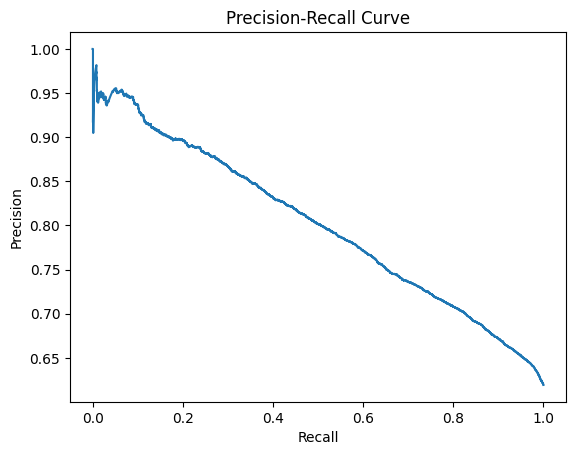

In [ ]:
tfidf = TfidfVectorizer(min_df = 25)
train_tfidf = tfidf.fit_transform(X_train["comment"])
test_tfidf = tfidf.transform(X_test["comment"])

X_train_1 = hstack([csr_matrix(X_train.drop(['comment', 'parent_comment'], axis =1).values), train_tfidf])
X_test_1 = hstack([csr_matrix(X_test.drop(['comment', 'parent_comment'], axis = 1).values), test_tfidf])

scaler = StandardScaler()
X_train_1_scaled = scaler.fit_transform(X_train_1.toarray())
X_test_1_scaled = scaler.transform(X_test_1.toarray())

pca = PCA(n_components = 0.99)
X_train_pca = pca.fit_transform(X_train_1_scaled)
X_test_pca = pca.transform(X_test_1_scaled)

log_reg1 = LogisticRegression(random_state = 123, max_iter = 1000)

log_reg1.fit(X_train_pca, y_train)
cv_scores = cross_val_score(log_reg1, X_train_pca, y_train, cv=5, scoring='precision')

y_pred = log_reg1.predict(X_test_pca)

y_pred_proba = log_reg1.predict_proba(X_test_pca)
auc_score = average_precision_score(y_test, y_pred_proba[:,1])
precision_pca, recall_pca, _ = precision_recall_curve(y_test, y_pred_proba[:,1])

print(f'Validation score: {np.mean(cv_scores)}')
print(f'Test score: {precision_score(y_test, y_pred)}')
print(f'AUC: {auc_score}')

plt.plot(recall_pca, precision_pca)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

### LDA

In [ ]:
tfidf = TfidfVectorizer(min_df = 25)
train_tfidf = tfidf.fit_transform(X_train["comment"])
test_tfidf = tfidf.transform(X_test["comment"])

X_train_2 = hstack([csr_matrix(X_train.drop(['comment', 'parent_comment'], axis =1).values), train_tfidf])
X_test_2 = hstack([csr_matrix(X_test.drop(['comment', 'parent_comment'], axis = 1).values), test_tfidf])

scaler = StandardScaler()
X_train_2_scaled = scaler.fit_transform(X_train_2.toarray())
X_test_2_scaled = scaler.transform(X_test_2.toarray())

lda = LDA(n_components = 1)
X_train_lda = lda.fit_transform(X_train_2_scaled, y_train)
X_test_lda = lda.transform(X_test_2_scaled)

Unbalanced

Validation score: 0.7275672154803994
Test score: 0.7100778455712182
AUC: 0.8028737233504366


Text(0.5, 1.0, 'Precision-Recall Curve')

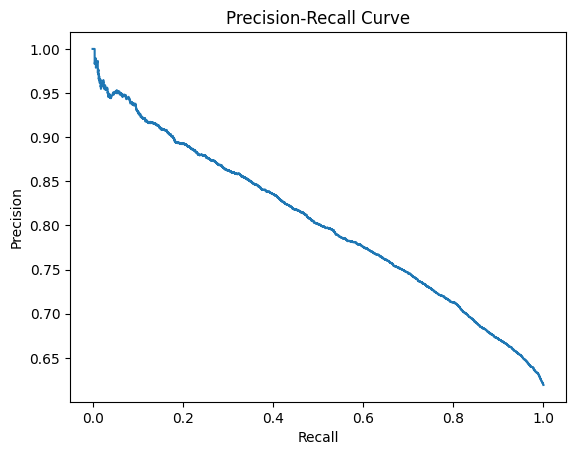

In [ ]:
log_reg1b = LogisticRegression(random_state = 123, max_iter = 1000)

log_reg1b.fit(X_train_lda, y_train)
cv_scores = cross_val_score(log_reg1b, X_train_lda, y_train, cv=5, scoring='precision')

y_pred = log_reg1b.predict(X_test_lda)

y_pred_proba_lda = log_reg1b.predict_proba(X_test_lda)
auc_score_lda = average_precision_score(y_test, y_pred_proba_lda[:,1])
precision_lda, recall_lda, _ = precision_recall_curve(y_test, y_pred_proba_lda[:,1])

print(f'Validation score: {np.mean(cv_scores)}')
print(f'Test score: {precision_score(y_test, y_pred)}')
print(f'AUC: {auc_score_lda}')
plt.plot(recall_lda, precision_lda, label = 'LDA')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Balanced

Validation score: 0.7826146434004435
Test score: 0.7599406803225508
AUC: 0.8028737233504366


Text(0.5, 1.0, 'Precision-Recall Curve')

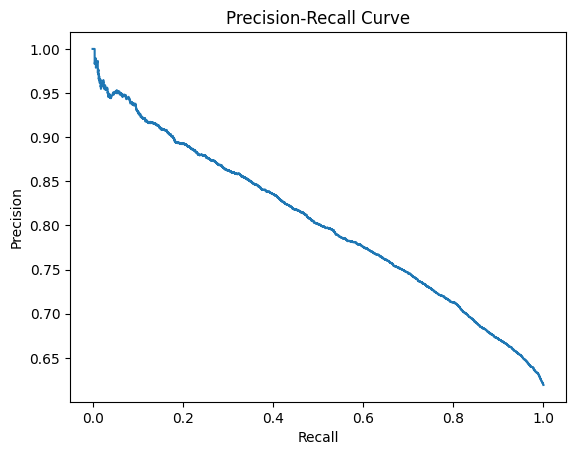

In [ ]:
log_reg1b_balance = LogisticRegression(random_state = 123, max_iter = 1000, class_weight = 'balanced', penalty = 'l2')

log_reg1b_balance.fit(X_train_lda, y_train)
cv_scores_balance = cross_val_score(log_reg1b_balance, X_train_lda, y_train, cv=5, scoring='precision')

y_pred_balance = log_reg1b_balance.predict(X_test_lda)

y_pred_proba_lda_balance = log_reg1b_balance.predict_proba(X_test_lda)
auc_score_lda_balance = average_precision_score(y_test, y_pred_proba_lda_balance[:,1])
precision_lda_balance, recall_lda_balance, _ = precision_recall_curve(y_test, y_pred_proba_lda_balance[:,1])

print(f'Validation score: {np.mean(cv_scores_balance)}')
print(f'Test score: {precision_score(y_test, y_pred_balance)}')
print(f'AUC: {auc_score_lda_balance}')
plt.plot(recall_lda_balance, precision_lda_balance, label = 'LDA')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

## BERT Embeddings

In [ ]:
train_bert = pd.read_pickle('/content/drive/My Drive/CS3244 Grp Project/Model training/BERT Embeddings/bert_embeddings_train.pkl')
# test_bert = pd.read_pickle('/content/drive/My Drive/bert_embeddings_test.pkl')

### No subreddit, no sentiment

In [ ]:
X_train_bert = train_bert.drop(['subreddit','comment', 'author', 'date', 'created_utc', 'parent_comment', 'label'], axis = 1)
y_train_bert = train_bert['label']
X_test_bert = test_bert.drop(['subreddit', 'comment', 'author', 'date', 'created_utc', 'parent_comment', 'label'], axis = 1)
y_test_bert = test_bert['label']

train_comment_bert = X_train_bert['bert_comment'].apply(lambda x: x[0])
comment_embeddings = pd.DataFrame(train_comment_bert.tolist(), columns = [f'dim_{i}' for i in range(768)])
train_parent_comment_bert = X_train_bert['bert_parent_comment'].apply(lambda x: x[0])
parent_comment_embeddings = pd.DataFrame(train_parent_comment_bert.tolist(), columns = [f'dim_{i}' for i in range(768)])

X_train_bert.drop(['bert_comment', 'bert_parent_comment'], axis = 1, inplace = True)
X_train_bert = X_train_bert.reset_index()
X_train_bert = pd.concat([X_train_bert, comment_embeddings, parent_comment_embeddings], axis = 1)
X_train_bert.drop('index', axis = 1, inplace = True)

test_comment_bert = X_test_bert['bert_comment'].apply(lambda x: x[0])
comment_embeddings = pd.DataFrame(test_comment_bert.tolist(), columns = [f'dim_{i}' for i in range(768)])
test_parent_comment_bert = X_test_bert['bert_parent_comment'].apply(lambda x: x[0])
parent_comment_embeddings = pd.DataFrame(test_parent_comment_bert.tolist(), columns = [f'dim_{i}' for i in range(768)])

X_test_bert.drop(['bert_comment', 'bert_parent_comment'], axis = 1, inplace = True)
X_test_bert = X_test_bert.reset_index()
X_test_bert = pd.concat([X_test_bert, comment_embeddings, parent_comment_embeddings], axis = 1)
X_test_bert.drop('index', axis = 1, inplace = True)


#### PCA

In [ ]:
scaler = StandardScaler()
X_train_bert_scaled = scaler.fit_transform(X_train_bert)
X_test_bert_scaled = scaler.transform(X_test_bert)

pca = PCA(n_components = 0.95)
X_train_bert_pca = pca.fit_transform(X_train_bert_scaled)
X_test_bert_pca = pca.transform(X_test_bert_scaled)

Unbalanced

Validation score: 0.7594172425800627
Test score: 0.7484863594273097
AUC: 0.8469727185076616


Text(0.5, 1.0, 'Precision-Recall Curve')

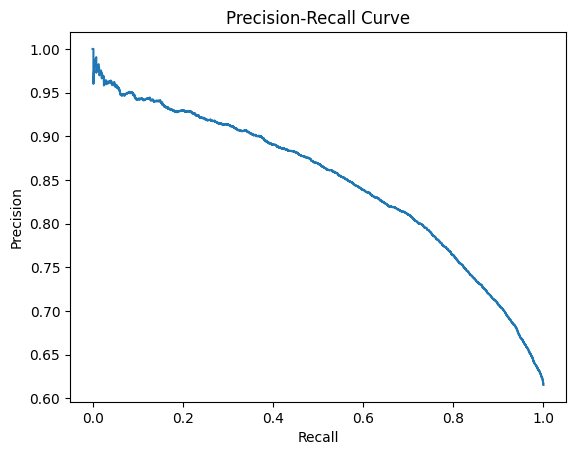

In [ ]:
log_reg_bert_pca = LogisticRegression(random_state = 123, max_iter = 1000)

log_reg_bert_pca.fit(X_train_bert_pca, y_train_bert)
cv_scores_bert_pca = cross_val_score(log_reg_bert_pca, X_train_bert_pca, y_train_bert, cv=5, scoring='precision')

y_pred_bert_pca = log_reg_bert_pca.predict(X_test_bert_pca)

y_pred_proba_bert_pca = log_reg_bert_pca.predict_proba(X_test_bert_pca)
auc_score_bert_pca = average_precision_score(y_test_bert, y_pred_proba_bert_pca[:,1])
precision_bert_pca, recall_bert_pca, _ = precision_recall_curve(y_test_bert, y_pred_proba_bert_pca[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_pca)}')
print(f'Test score: {precision_score(y_test_bert, y_pred_bert_pca)}')
print(f'AUC: {auc_score_bert_pca}')

plt.plot(recall_bert_pca, precision_bert_pca)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Balanced

Validation score: 0.8051962149608883
Test score: 0.8066100937918713
AUC: 0.8478212754602379


Text(0.5, 1.0, 'Precision-Recall Curve')

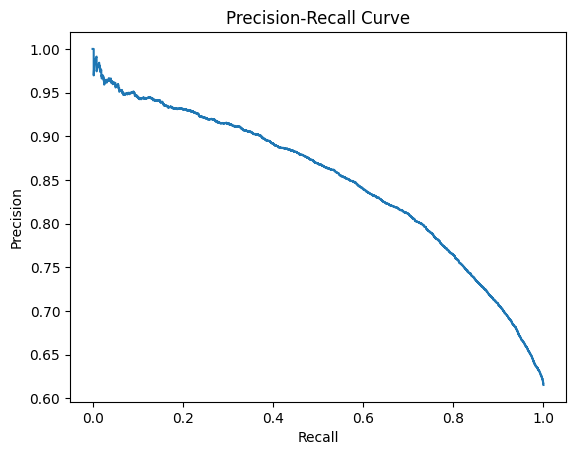

In [ ]:
log_reg_bert_pca_balance = LogisticRegression(random_state = 123, max_iter = 1000, class_weight = 'balanced')

log_reg_bert_pca_balance.fit(X_train_bert_pca, y_train_bert)
cv_scores_bert_pca_balance = cross_val_score(log_reg_bert_pca_balance, X_train_bert_pca, y_train_bert, cv=5, scoring='precision')

y_pred_bert_pca_balance = log_reg_bert_pca_balance.predict(X_test_bert_pca)

y_pred_proba_bert_pca_balance = log_reg_bert_pca_balance.predict_proba(X_test_bert_pca)
auc_score_bert_pca_balance = average_precision_score(y_test_bert, y_pred_proba_bert_pca_balance[:,1])
precision_bert_pca_balance, recall_bert_pca_balance, _ = precision_recall_curve(y_test_bert, y_pred_proba_bert_pca_balance[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_pca_balance)}')
print(f'Test score: {precision_score(y_test_bert, y_pred_bert_pca_balance)}')
print(f'AUC: {auc_score_bert_pca_balance}')

plt.plot(recall_bert_pca_balance, precision_bert_pca_balance)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

#### LDA

In [ ]:
scaler = StandardScaler()
X_train_bert_scaled = scaler.fit_transform(X_train_bert)
X_test_bert_scaled = scaler.transform(X_test_bert)

lda = LDA(n_components = 1)
X_train_bert_lda = lda.fit_transform(X_train_bert_scaled, y_train_bert)
X_test_bert_lda = lda.transform(X_test_bert_scaled)

Unbalanced

Validation score: 0.7697064644078204
Test score: 0.7624936718015477
AUC: 0.8583026893141246


Text(0.5, 1.0, 'Precision-Recall Curve')

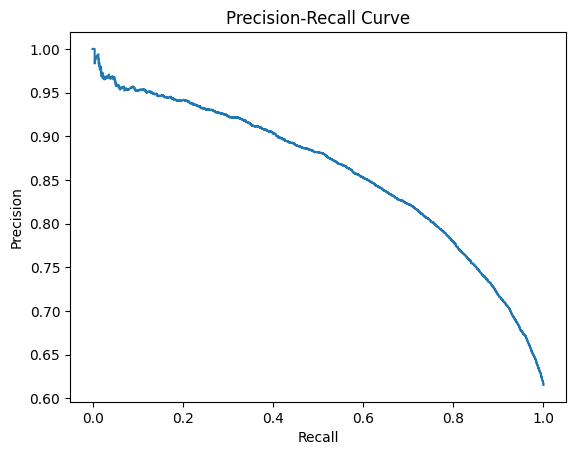

In [ ]:
log_reg_bert_lda = LogisticRegression(random_state = 123, max_iter = 1000)

log_reg_bert_lda.fit(X_train_bert_lda, y_train_bert)
cv_scores_bert_lda = cross_val_score(log_reg_bert_lda, X_train_bert_lda, y_train_bert, cv=5, scoring='precision')

y_pred_bert_lda = log_reg_bert_lda.predict(X_test_bert_lda)

y_pred_proba_bert_lda = log_reg_bert_lda.predict_proba(X_test_bert_lda)
auc_score_bert_lda = average_precision_score(y_test_bert, y_pred_proba_bert_lda[:,1])
precision_bert_lda, recall_bert_lda, _ = precision_recall_curve(y_test_bert, y_pred_proba_bert_lda[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_lda)}')
print(f'Test score: {precision_score(y_test_bert, y_pred_bert_lda)}')
print(f'AUC: {auc_score_bert_lda}')

plt.plot(recall_bert_lda, precision_bert_lda)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Balanced

Validation score: 0.8201910859422114
Test score: 0.814453989903463
AUC: 0.8583026893141246


Text(0.5, 1.0, 'Precision-Recall Curve')

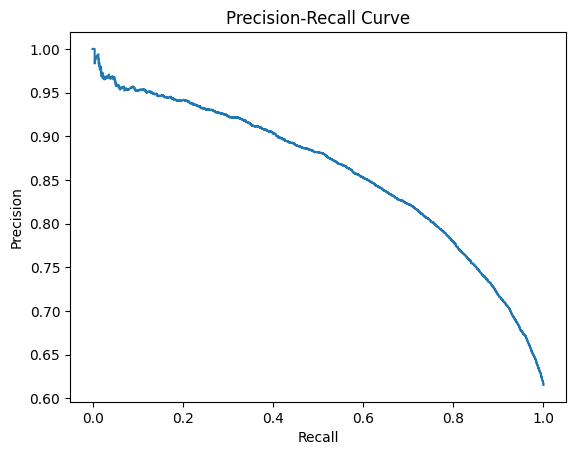

In [ ]:
log_reg_bert_lda_balance = LogisticRegression(random_state = 123, max_iter = 1000, class_weight = 'balanced')

log_reg_bert_lda_balance.fit(X_train_bert_lda, y_train_bert)
cv_scores_bert_lda_balance = cross_val_score(log_reg_bert_lda_balance, X_train_bert_lda, y_train_bert, cv=5, scoring='precision')

y_pred_bert_lda_balance = log_reg_bert_lda_balance.predict(X_test_bert_lda)

y_pred_proba_bert_lda_balance = log_reg_bert_lda_balance.predict_proba(X_test_bert_lda)
auc_score_bert_lda_balance = average_precision_score(y_test_bert, y_pred_proba_bert_lda_balance[:,1])
precision_bert_lda_balance, recall_bert_lda_balance, _ = precision_recall_curve(y_test_bert, y_pred_proba_bert_lda_balance[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_lda_balance)}')
print(f'Test score: {precision_score(y_test_bert, y_pred_bert_lda_balance)}')
print(f'AUC: {auc_score_bert_lda_balance}')

plt.plot(recall_bert_lda_balance, precision_bert_lda_balance)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Text(0.5, 1.0, 'Precision-Recall Curve')

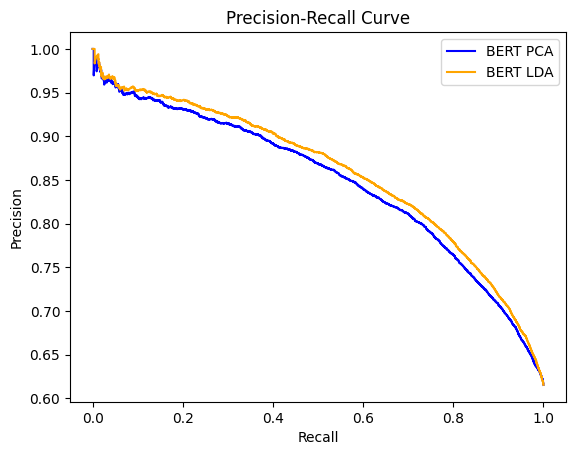

In [ ]:
plt.plot(recall_bert_pca_balance, precision_bert_pca_balance, color = 'blue', label = 'BERT PCA')
plt.plot(recall_bert_lda_balance, precision_bert_lda_balance, color = 'orange', label = 'BERT LDA')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

### Subreddit no sentiment

In [ ]:
train_bert_subreddit = pd.read_pickle('/content/drive/My Drive/bert_embeddings_train.pkl')
test_bert_subreddit = pd.read_pickle('/content/drive/My Drive/bert_embeddings_test.pkl')

In [ ]:
X_train_bert_subreddit = train_bert_subreddit.drop(['comment', 'author', 'date', 'created_utc', 'parent_comment', 'label'], axis = 1)
y_train_bert_subreddit = train_bert_subreddit['label']
X_test_bert_subreddit = test_bert_subreddit.drop(['comment', 'author', 'date', 'created_utc', 'parent_comment', 'label'], axis = 1)
y_test_bert_subreddit = test_bert_subreddit['label']

train_comment_bert_subreddit = X_train_bert_subreddit['bert_comment'].apply(lambda x: x[0])
comment_embeddings = pd.DataFrame(train_comment_bert_subreddit.tolist(), columns = [f'dim_{i}' for i in range(768)])
train_parent_comment_bert_subreddit = X_train_bert_subreddit['bert_parent_comment'].apply(lambda x: x[0])
parent_comment_embeddings = pd.DataFrame(train_parent_comment_bert_subreddit.tolist(), columns = [f'dim_{i}' for i in range(768)])

X_train_bert_subreddit.drop(['bert_comment', 'bert_parent_comment'], axis = 1, inplace = True)
X_train_bert_subreddit = X_train_bert_subreddit.reset_index()
X_train_bert_subreddit = pd.concat([X_train_bert_subreddit, comment_embeddings, parent_comment_embeddings], axis = 1)
X_train_bert_subreddit.drop('index', axis = 1, inplace = True)
X_train_bert_subreddit = pd.get_dummies(X_train_bert_subreddit, columns = ['subreddit'])

test_comment_bert_subreddit = X_test_bert_subreddit['bert_comment'].apply(lambda x: x[0])
comment_embeddings_subreddit = pd.DataFrame(test_comment_bert_subreddit.tolist(), columns = [f'dim_{i}' for i in range(768)])
test_parent_comment_bert_subreddit = X_test_bert_subreddit['bert_parent_comment'].apply(lambda x: x[0])
parent_comment_embeddings_subreddit = pd.DataFrame(test_parent_comment_bert_subreddit.tolist(), columns = [f'dim_{i}' for i in range(768)])

X_test_bert_subreddit.drop(['bert_comment', 'bert_parent_comment'], axis = 1, inplace = True)
X_test_bert_subreddit = X_test_bert_subreddit.reset_index()
X_test_bert_subreddit = pd.concat([X_test_bert_subreddit, comment_embeddings_subreddit, parent_comment_embeddings_subreddit], axis = 1)
X_test_bert_subreddit.drop('index', axis = 1, inplace = True)
X_test_bert_subreddit = pd.get_dummies(X_test_bert_subreddit, columns = ['subreddit'])


KeyboardInterrupt: 

##### PCA

In [ ]:
scaler = StandardScaler()
X_train_bert_subreddit_scaled = scaler.fit_transform(X_train_bert_subreddit)
X_test_bert_subreddit_scaled = scaler.transform(X_test_bert_subreddit)

pca = PCA(n_components = 0.95)
X_train_bert_subreddit_pca = pca.fit_transform(X_train_bert_subreddit_scaled)
X_test_bert_subreddit_pca = pca.transform(X_test_bert_subreddit_scaled)

Unbalanced

Validation score: 0.759003009111106
Test score: 0.7489134307089419
AUC: 0.8473535561395342


Text(0.5, 1.0, 'Precision-Recall Curve')

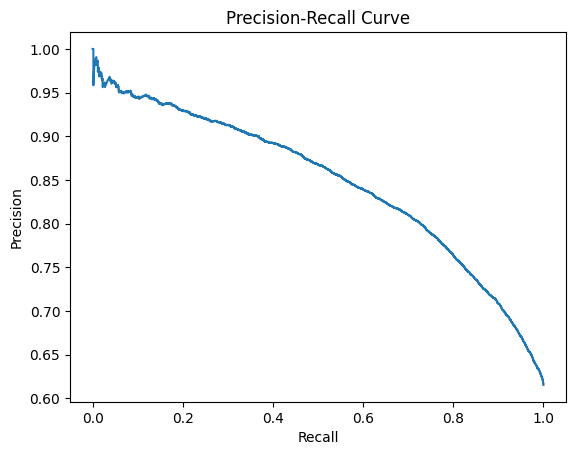

In [ ]:
log_reg_bert_subreddit_pca = LogisticRegression(random_state = 123, max_iter = 1000)

log_reg_bert_subreddit_pca.fit(X_train_bert_subreddit_pca, y_train_bert_subreddit)
cv_scores_bert_subreddit_pca = cross_val_score(log_reg_bert_subreddit_pca, X_train_bert_subreddit_pca, y_train_bert_subreddit, cv=5, scoring='precision')

y_pred_bert_subreddit_pca = log_reg_bert_subreddit_pca.predict(X_test_bert_subreddit_pca)

y_pred_proba_bert_subreddit_pca = log_reg_bert_subreddit_pca.predict_proba(X_test_bert_subreddit_pca)
auc_score_bert_subreddit_pca = average_precision_score(y_test_bert_subreddit, y_pred_proba_bert_subreddit_pca[:,1])
precision_bert_subreddit_pca, recall_bert_subreddit_pca, _ = precision_recall_curve(y_test_bert_subreddit, y_pred_proba_bert_subreddit_pca[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_subreddit_pca)}')
print(f'Test score: {precision_score(y_test_bert_subreddit, y_pred_bert_subreddit_pca)}')
print(f'AUC: {auc_score_bert_subreddit_pca}')

plt.plot(recall_bert_subreddit_pca, precision_bert_subreddit_pca)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Balanced

Validation score: 0.8047686354687544
Test score: 0.8067054090299508
AUC: 0.8481732056554856


Text(0.5, 1.0, 'Precision-Recall Curve')

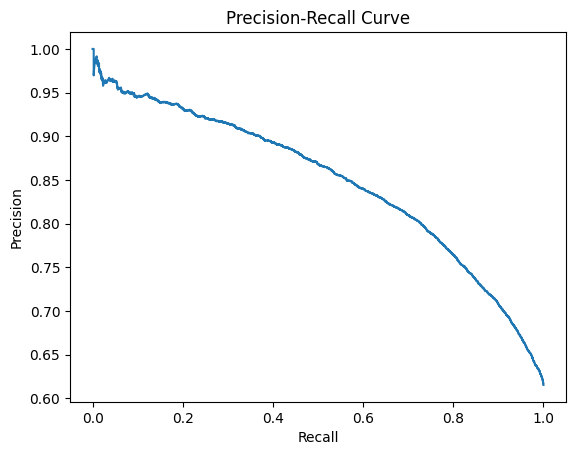

In [ ]:
log_reg_bert_subreddit_pca_balance = LogisticRegression(random_state = 123, max_iter = 1000, class_weight = 'balanced')

log_reg_bert_subreddit_pca_balance.fit(X_train_bert_subreddit_pca, y_train_bert_subreddit)
cv_scores_bert_subreddit_pca_balance = cross_val_score(log_reg_bert_subreddit_pca_balance, X_train_bert_subreddit_pca, y_train_bert_subreddit, cv=5, scoring='precision')

y_pred_bert_subreddit_pca_balance = log_reg_bert_subreddit_pca_balance.predict(X_test_bert_subreddit_pca)

y_pred_proba_bert_subreddit_pca_balance = log_reg_bert_subreddit_pca_balance.predict_proba(X_test_bert_subreddit_pca)
auc_score_bert_subreddit_pca_balance = average_precision_score(y_test_bert_subreddit, y_pred_proba_bert_subreddit_pca_balance[:,1])
precision_bert_subreddit_pca_balance, recall_bert_subreddit_pca_balance, _ = precision_recall_curve(y_test_bert_subreddit, y_pred_proba_bert_subreddit_pca_balance[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_subreddit_pca_balance)}')
print(f'Test score: {precision_score(y_test_bert_subreddit, y_pred_bert_subreddit_pca_balance)}')
print(f'AUC: {auc_score_bert_subreddit_pca_balance}')

plt.plot(recall_bert_subreddit_pca_balance, precision_bert_subreddit_pca_balance)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

##### LDA

In [ ]:
lda = LDA(n_components = 1)
X_train_bert_subreddit_lda = lda.fit_transform(X_train_bert_subreddit_scaled, y_train_bert_subreddit)
X_test_bert_subreddit_lda = lda.transform(X_test_bert_subreddit_scaled)

Unbalanced

Validation score: 0.7699678254705227
Test score: 0.7630149880530013
AUC: 0.8587121903245178


Text(0.5, 1.0, 'Precision-Recall Curve')

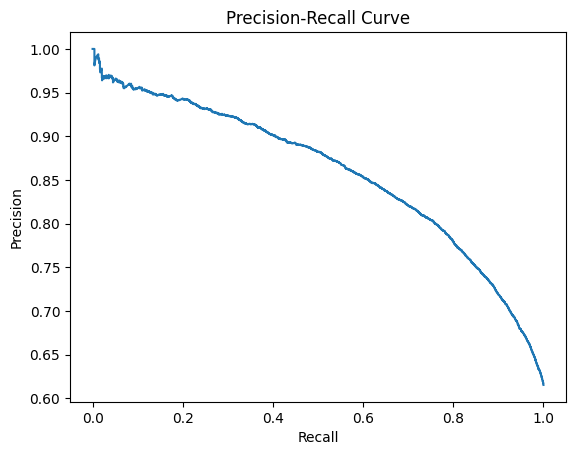

In [ ]:
log_reg_bert_subreddit_lda = LogisticRegression(random_state = 123, max_iter = 1000)

log_reg_bert_subreddit_lda.fit(X_train_bert_subreddit_lda, y_train_bert_subreddit)
cv_scores_bert_subreddit_lda = cross_val_score(log_reg_bert_subreddit_lda, X_train_bert_subreddit_lda, y_train_bert_subreddit, cv=5, scoring='precision')

y_pred_bert_subreddit_lda = log_reg_bert_subreddit_lda.predict(X_test_bert_subreddit_lda)

y_pred_proba_bert_subreddit_lda = log_reg_bert_subreddit_lda.predict_proba(X_test_bert_subreddit_lda)
auc_score_bert_subreddit_lda = average_precision_score(y_test_bert_subreddit, y_pred_proba_bert_subreddit_lda[:,1])
precision_bert_subreddit_lda, recall_bert_subreddit_lda, _ = precision_recall_curve(y_test_bert_subreddit, y_pred_proba_bert_subreddit_lda[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_subreddit_lda)}')
print(f'Test score: {precision_score(y_test_bert_subreddit, y_pred_bert_subreddit_lda)}')
print(f'AUC: {auc_score_bert_subreddit_lda}')

plt.plot(recall_bert_subreddit_lda, precision_bert_subreddit_lda)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Balanced

Validation score: 0.8197916356450374
Test score: 0.8133911965282083
AUC: 0.8587121903245178


Text(0.5, 1.0, 'Precision-Recall Curve')

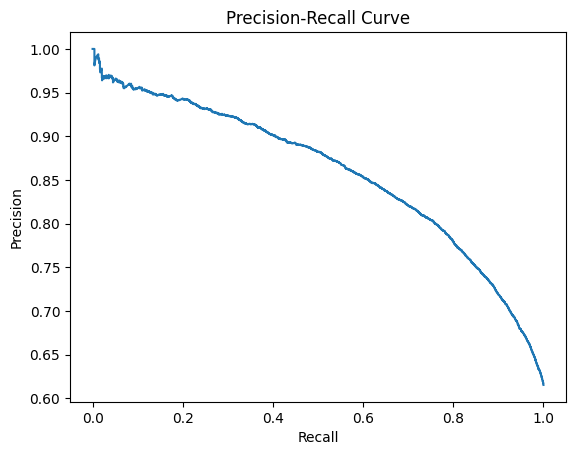

In [ ]:
log_reg_bert_subreddit_lda_balance = LogisticRegression(random_state = 123, max_iter = 1000, class_weight = 'balanced')

log_reg_bert_subreddit_lda_balance.fit(X_train_bert_subreddit_lda, y_train_bert_subreddit)
cv_scores_bert_subreddit_lda_balance = cross_val_score(log_reg_bert_subreddit_lda_balance, X_train_bert_subreddit_lda, y_train_bert_subreddit, cv=5, scoring='precision')

y_pred_bert_subreddit_lda_balance = log_reg_bert_subreddit_lda_balance.predict(X_test_bert_subreddit_lda)

y_pred_proba_bert_subreddit_lda_balance = log_reg_bert_subreddit_lda_balance.predict_proba(X_test_bert_subreddit_lda)
auc_score_bert_subreddit_lda_balance = average_precision_score(y_test_bert_subreddit, y_pred_proba_bert_subreddit_lda_balance[:,1])
precision_bert_subreddit_lda_balance, recall_bert_subreddit_lda_balance, _ = precision_recall_curve(y_test_bert_subreddit, y_pred_proba_bert_subreddit_lda_balance[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_subreddit_lda_balance)}')
print(f'Test score: {precision_score(y_test_bert_subreddit, y_pred_bert_subreddit_lda_balance)}')
print(f'AUC: {auc_score_bert_subreddit_lda_balance}')

plt.plot(recall_bert_subreddit_lda_balance, precision_bert_subreddit_lda_balance)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

### With subreddit and sentiment

In [ ]:
train_bert_sentiment = pd.read_pickle('/content/drive/My Drive/CS3244 Grp Project/Model training/BERT Embeddings/bert_embeddings_no_pooling_train.pkl')
# test_bert_sentiment = pd.read_pickle('/content/drive/My Drive/bert_embeddings_test.pkl')

In [ ]:
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer

def get_polarity(x):
  return TextBlob(x, analyzer=PatternAnalyzer()).sentiment.polarity

def get_subjectivity(x):
  return TextBlob(x, analyzer=PatternAnalyzer()).sentiment.subjectivity

train_bert_sentiment["comment_polarity"] = train_bert_sentiment["comment"].apply(lambda x: get_polarity(x))
train_bert_sentiment["comment_subjectivity"] = train_bert_sentiment["comment"].apply(lambda x: get_subjectivity(x))
train_bert_sentiment["parent_polarity"] = train_bert_sentiment["parent_comment"].apply(lambda x: get_polarity(x))
train_bert_sentiment["parent_subjectivity"] = train_bert_sentiment["parent_comment"].apply(lambda x: get_subjectivity(x))
# test_bert_sentiment["comment_polarity"] = test_bert_sentiment["comment"].apply(lambda x: get_polarity(x))
# test_bert_sentiment["comment_subjectivity"] = test_bert_sentiment["comment"].apply(lambda x: get_subjectivity(x))
# test_bert_sentiment["parent_polarity"] = test_bert_sentiment["parent_comment"].apply(lambda x: get_polarity(x))
# test_bert_sentiment["parent_subjectivity"] = test_bert_sentiment["parent_comment"].apply(lambda x: get_subjectivity(x))

In [ ]:
for i in range(6):
  print(i)
  train_bert_sentiment[f'embed_{i}'] = train_bert_sentiment['bert_comment'].apply(lambda x: x[0][0][i])


0
1
2
3
4
5


In [ ]:
train_bert_sentiment['bert_comment'].apply(lambda x: pd.Series(x[0][0]))


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.265913,-0.298828,-0.040225,-0.342138,0.208334,-0.198421,0.304811,0.526545,-0.242345,-0.383906,...,0.063218,0.042284,0.118114,-0.215914,0.433673,-0.513255,-0.036348,-0.110899,0.429443,0.386235
10,0.075774,0.035001,-0.042445,-0.059997,0.033418,-0.096583,0.011946,0.258756,-0.130929,-0.285314,...,-0.174008,-0.137866,0.033288,0.113162,0.280081,-0.048417,-0.007624,0.021943,0.270065,0.277205
17,0.032996,0.049395,-0.082889,-0.163493,0.122008,-0.204610,0.173618,0.428245,-0.147454,-0.295174,...,0.055894,-0.295340,0.190627,-0.164036,0.120010,0.064845,-0.020887,0.086642,0.387942,0.219054
22,-0.157952,-0.007969,-0.336572,-0.091080,-0.281804,-0.148273,0.259573,0.417556,-0.208815,-0.346131,...,-0.045017,-0.101335,0.048763,-0.175353,0.114207,-0.142464,0.111002,-0.220070,0.279296,0.596728
23,-0.093258,-0.088154,-0.058376,-0.069232,0.057258,-0.181016,-0.024800,0.193428,-0.145071,-0.167975,...,-0.015953,0.006360,0.102496,0.006325,0.024589,0.153821,-0.121200,-0.122079,0.300069,0.275356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010808,0.136452,-0.047203,-0.190711,-0.086990,-0.081005,-0.147695,0.309160,0.343443,-0.063818,-0.254665,...,-0.104201,-0.174760,0.016274,-0.189969,0.041624,-0.030631,-0.006211,0.006340,0.270537,0.444586
1010811,0.002203,0.035777,0.047629,-0.050098,-0.068773,-0.082642,0.078428,0.361107,-0.179791,-0.287752,...,0.057843,-0.315034,0.196093,-0.162130,0.265105,-0.072147,-0.136788,-0.135123,0.243997,0.294115
1010820,-0.189086,-0.132872,0.176215,-0.315826,-0.034384,-0.004645,0.202538,0.353635,-0.254664,-0.132161,...,0.184008,-0.081706,0.140308,-0.009700,0.171118,-0.152658,-0.044453,-0.120323,0.183321,0.485320
1010824,-0.165596,-0.102045,-0.230741,-0.167725,-0.296198,-0.065518,0.323496,0.492700,-0.421836,-0.132316,...,0.110749,-0.030094,0.421125,-0.066687,0.348110,-0.037315,-0.392066,-0.475488,0.290971,0.407646


In [ ]:
train_bert_sentiment['bert_comment'][1]

KeyError: 1

In [ ]:
bert_embeddings = train_bert_sentiment['bert_comment'].apply(lambda x: pd.Series(x.reshape(768,)))
bert_embeddings.columns = [f'dim_{i}' for i in range(768)]
train_bert_sentiment = pd.concat([train_bert_sentiment, bert_embeddings], axis = 1)

In [ ]:
X_train_bert_sentiment = train_bert_sentiment.drop(['comment', 'author', 'date', 'created_utc', 'parent_comment', 'label'], axis = 1)
y_train_bert_sentiment = train_bert_sentiment['label']
# X_test_bert_sentiment = test_bert_sentiment.drop(['comment', 'author', 'date', 'created_utc', 'parent_comment', 'label'], axis = 1)
# y_test_bert_sentiment = test_bert_sentiment['label']

train_comment_bert = X_train_bert_sentiment['bert_comment'].apply(lambda x: x[0])
comment_embeddings = pd.DataFrame(train_comment_bert.tolist(), columns = [f'dim_{i}' for i in range(768)])
train_parent_comment_bert = X_train_bert_sentiment['bert_parent_comment'].apply(lambda x: x[0])
parent_comment_embeddings = pd.DataFrame(train_parent_comment_bert.tolist(), columns = [f'dim_{i}' for i in range(768)])

X_train_bert_sentiment.drop(['bert_comment', 'bert_parent_comment'], axis = 1, inplace = True)
X_train_bert_sentiment = X_train_bert_sentiment.reset_index()
X_train_bert_sentiment = pd.concat([X_train_bert_sentiment, comment_embeddings, parent_comment_embeddings], axis = 1)
X_train_bert_sentiment.drop('index', axis = 1, inplace = True)
X_train_bert_sentiment = pd.get_dummies(X_train_bert_sentiment, columns = ['subreddit'])

# test_comment_bert = X_test_bert_sentiment['bert_comment'].apply(lambda x: x[0])
# comment_embeddings = pd.DataFrame(test_comment_bert.tolist(), columns = [f'dim_{i}' for i in range(768)])
# test_parent_comment_bert = X_test_bert_sentiment['bert_parent_comment'].apply(lambda x: x[0])
# parent_comment_embeddings = pd.DataFrame(test_parent_comment_bert.tolist(), columns = [f'dim_{i}' for i in range(768)])

# X_test_bert_sentiment.drop(['bert_comment', 'bert_parent_comment'], axis = 1, inplace = True)
# X_test_bert_sentiment = X_test_bert_sentiment.reset_index()
# X_test_bert_sentiment = pd.concat([X_test_bert_sentiment, comment_embeddings, parent_comment_embeddings], axis = 1)
# X_test_bert_sentiment.drop('index', axis = 1, inplace = True)
# X_test_bert_sentiment = pd.get_dummies(X_test_bert_sentiment, columns = ['subreddit'])


#### PCA

In [ ]:
scaler = StandardScaler()
X_train_bert_sentiment_scaled = scaler.fit_transform(X_train_bert_sentiment)
X_test_bert_sentiment_scaled = scaler.transform(X_test_bert_sentiment)

pca = PCA(n_components = 0.95)
X_train_bert_sentiment_pca = pca.fit_transform(X_train_bert_sentiment_scaled)
X_test_bert_sentiment_pca = pca.transform(X_test_bert_sentiment_scaled)

Unbalanced

Validation score: 0.759004839271171
Test score: 0.7485226059095763
AUC: 0.8473482092225071


Text(0.5, 1.0, 'Precision-Recall Curve')

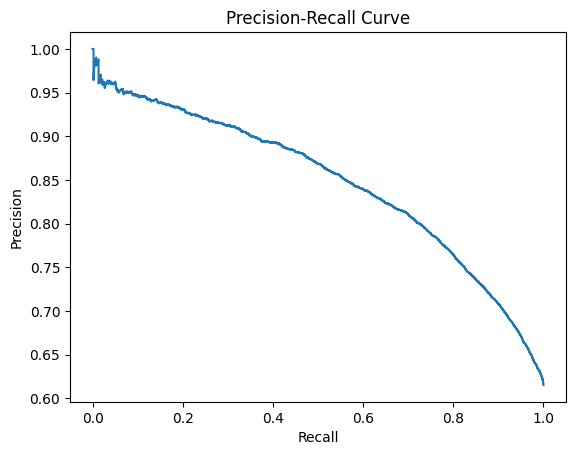

In [ ]:
log_reg_bert_sentiment_pca = LogisticRegression(random_state = 123, max_iter = 1000)

log_reg_bert_sentiment_pca.fit(X_train_bert_sentiment_pca, y_train_bert_sentiment)
cv_scores_bert_sentiment_pca = cross_val_score(log_reg_bert_sentiment_pca, X_train_bert_sentiment_pca, y_train_bert_sentiment, cv=5, scoring='precision')

y_pred_bert_sentiment_pca = log_reg_bert_sentiment_pca.predict(X_test_bert_sentiment_pca)

y_pred_proba_bert_sentiment_pca = log_reg_bert_sentiment_pca.predict_proba(X_test_bert_sentiment_pca)
auc_score_bert_sentiment_pca = average_precision_score(y_test_bert_sentiment, y_pred_proba_bert_sentiment_pca[:,1])
precision_bert_sentiment_pca, recall_bert_sentiment_pca, _ = precision_recall_curve(y_test_bert_sentiment, y_pred_proba_bert_sentiment_pca[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_sentiment_pca)}')
print(f'Test score: {precision_score(y_test_bert_sentiment, y_pred_bert_sentiment_pca)}')
print(f'AUC: {auc_score_bert_sentiment_pca}')

plt.plot(recall_bert_sentiment_pca, precision_bert_sentiment_pca)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Balanced

Validation score: 0.8055027971044779
Test score: 0.8063767080467983
AUC: 0.8481611452487738


Text(0.5, 1.0, 'Precision-Recall Curve')

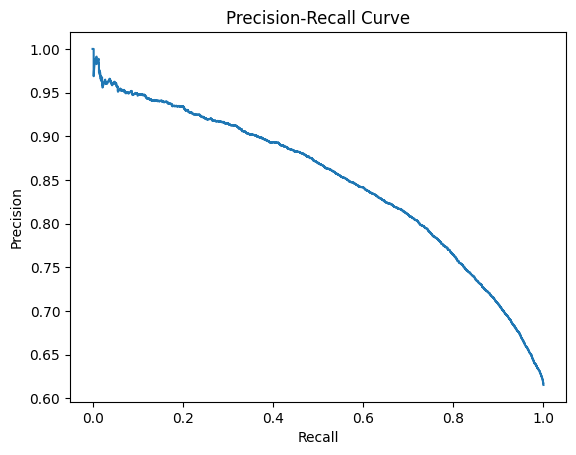

In [ ]:
log_reg_bert_sentiment_pca_balance = LogisticRegression(random_state = 123, max_iter = 1000, class_weight = 'balanced')

log_reg_bert_sentiment_pca_balance.fit(X_train_bert_sentiment_pca, y_train_bert_sentiment)
cv_scores_bert_sentiment_pca_balance = cross_val_score(log_reg_bert_sentiment_pca_balance, X_train_bert_sentiment_pca, y_train_bert_sentiment, cv=5, scoring='precision')

y_pred_bert_sentiment_pca_balance = log_reg_bert_sentiment_pca_balance.predict(X_test_bert_sentiment_pca)

y_pred_proba_bert_sentiment_pca_balance = log_reg_bert_sentiment_pca_balance.predict_proba(X_test_bert_sentiment_pca)
auc_score_bert_sentiment_pca_balance = average_precision_score(y_test_bert_sentiment, y_pred_proba_bert_sentiment_pca_balance[:,1])
precision_bert_sentiment_pca_balance, recall_bert_sentiment_pca_balance, _ = precision_recall_curve(y_test_bert_sentiment, y_pred_proba_bert_sentiment_pca_balance[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_sentiment_pca_balance)}')
print(f'Test score: {precision_score(y_test_bert_sentiment, y_pred_bert_sentiment_pca_balance)}')
print(f'AUC: {auc_score_bert_sentiment_pca_balance}')

plt.plot(recall_bert_sentiment_pca_balance, precision_bert_sentiment_pca_balance)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

#### LDA

In [ ]:
lda = LDA(n_components = 1)
X_train_bert_sentiment_lda = lda.fit_transform(X_train_bert_sentiment_scaled, y_train_bert_sentiment)
X_test_bert_sentiment_lda = lda.transform(X_test_bert_sentiment_scaled)

Unbalanced

Validation score: 0.7701757883455767
Test score: 0.7634836747991023
AUC: 0.8588036666774905


Text(0.5, 1.0, 'Precision-Recall Curve')

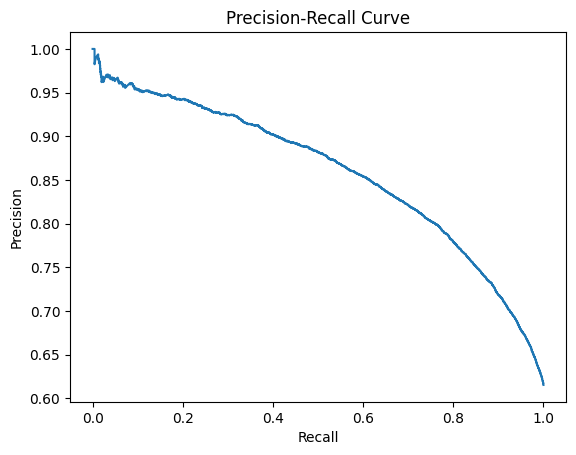

In [ ]:
log_reg_bert_sentiment_lda = LogisticRegression(random_state = 123, max_iter = 1000)

log_reg_bert_sentiment_lda.fit(X_train_bert_sentiment_lda, y_train_bert_sentiment)
cv_scores_bert_sentiment_lda = cross_val_score(log_reg_bert_sentiment_lda, X_train_bert_sentiment_lda, y_train_bert_sentiment, cv=5, scoring='precision')

y_pred_bert_sentiment_lda = log_reg_bert_sentiment_lda.predict(X_test_bert_sentiment_lda)

y_pred_proba_bert_sentiment_lda = log_reg_bert_sentiment_lda.predict_proba(X_test_bert_sentiment_lda)
auc_score_bert_sentiment_lda = average_precision_score(y_test_bert_sentiment, y_pred_proba_bert_sentiment_lda[:,1])
precision_bert_sentiment_lda, recall_bert_sentiment_lda, _ = precision_recall_curve(y_test_bert_sentiment, y_pred_proba_bert_sentiment_lda[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_sentiment_lda)}')
print(f'Test score: {precision_score(y_test_bert_sentiment, y_pred_bert_sentiment_lda)}')
print(f'AUC: {auc_score_bert_sentiment_lda}')

plt.plot(recall_bert_sentiment_lda, precision_bert_sentiment_lda)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Balanced

Validation score: 0.8207630224139597
Test score: 0.8133958591399753
AUC: 0.8588036666774905


Text(0.5, 1.0, 'Precision-Recall Curve')

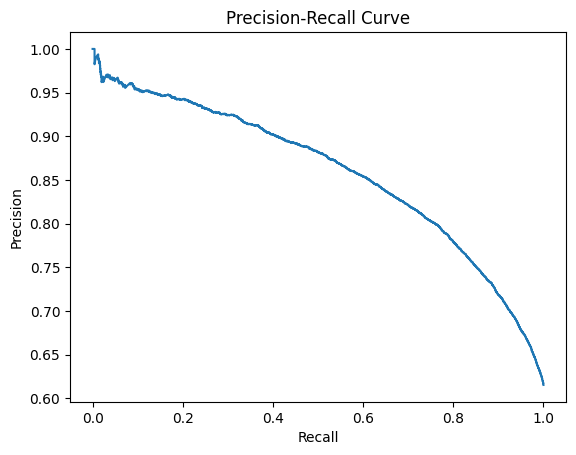

In [ ]:
log_reg_bert_sentiment_lda_balance = LogisticRegression(random_state = 123, max_iter = 1000, class_weight = 'balanced')

log_reg_bert_sentiment_lda_balance.fit(X_train_bert_sentiment_lda, y_train_bert_sentiment)
cv_scores_bert_sentiment_lda_balance = cross_val_score(log_reg_bert_sentiment_lda_balance, X_train_bert_sentiment_lda, y_train_bert_sentiment, cv=5, scoring='precision')

y_pred_bert_sentiment_lda_balance = log_reg_bert_sentiment_lda_balance.predict(X_test_bert_sentiment_lda)

y_pred_proba_bert_sentiment_lda_balance = log_reg_bert_sentiment_lda_balance.predict_proba(X_test_bert_sentiment_lda)
auc_score_bert_sentiment_lda_balance = average_precision_score(y_test_bert_sentiment, y_pred_proba_bert_sentiment_lda_balance[:,1])
precision_bert_sentiment_lda_balance, recall_bert_sentiment_lda_balance, _ = precision_recall_curve(y_test_bert_sentiment, y_pred_proba_bert_sentiment_lda_balance[:,1])

print(f'Validation score: {np.mean(cv_scores_bert_sentiment_lda_balance)}')
print(f'Test score: {precision_score(y_test_bert_sentiment, y_pred_bert_sentiment_lda_balance)}')
print(f'AUC: {auc_score_bert_sentiment_lda_balance}')

plt.plot(recall_bert_sentiment_lda_balance, precision_bert_sentiment_lda_balance)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Ignore (round 1)

## Preprocessing from EDA

###Kaggle Stuff

In [ ]:
!pip install kaggle
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=479790ddffa76acf2a7ddcfcebee9cbd67aaa31ec2ef98f62a6916858dc83ccd
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/My\ Drive/Dell/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d danofer/sarcasm
!unzip sarcasm.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/danofer/sarcasm
License(s): copyright-authors
sarcasm.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sarcasm.zip
replace test-balanced.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test-unbalanced.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train-balanced-sarc.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train-balanced-sarc.csv.gz  
replace train-balanced-sarcasm.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train-balanced-sarcasm.csv  


###Read Data

In [ ]:
import spacy
import re
import string
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [ ]:
df = pd.read_csv('train-balanced-sarcasm.csv')
df = df.dropna()

###Data Cleaning and Preprocessing

In [ ]:
#Remove all na rows
df = df.dropna()

#Selecting only the comment and label column
filtered_df = df[df['subreddit'].isin(['news', 'politics', 'worldnews'])]
# filtered_test = test[test['subreddit'].isin(['news', 'politics', 'worldnews'])]
comments = filtered_df.loc[:,["label", "comment", "parent_comment"]]

#Word count column
comments["word_count"] = comments["comment"].apply(lambda x: len(x.split()))

#Capital letter counts
def count_cap(x):
  result = 0
  for c in x:
    if c.isupper():
      result += 1
  return result

comments["capital_count"] = comments["comment"].apply(lambda x: count_cap(x))

#Punctuation count
comments["punc_count"] = comments["comment"].apply(lambda x: sum(1 for i in x if i in string.punctuation))

#Lower case
comments["comment"] = comments["comment"].apply(lambda x: x.lower())
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: x.lower())

In [ ]:
#List of contractions manually modified for convenience
contractions = {
"i ain't": "i am not",
"you ain't": "you are not",
"he ain't": "he is not",
"she ain't": "she is not",
"they ain't": "they are not",
"it ain't": "it is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": " what is",
"what've": "what have",
"when's": " when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}


In [ ]:
#Expand words
def decontract(words):
  final = []
  for word in words:
    if word in contractions:
      final.append(contractions[word])
    else:
      final.append(word)
  return " ".join(final)

comments["comment"] = comments["comment"].apply(lambda x: decontract(x.split()))
comments["comment"] = comments["comment"].apply(lambda x: re.sub(r"\'s", " is", x))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: decontract(x.split()))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: re.sub(r"\'s", " is", x))

# Remove punctuation

comments["comment"] = comments["comment"].apply(lambda x: re.sub(r'[^\w ]+', "", x))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: re.sub(r'[^\w ]+', "", x))

In [ ]:
#Remove stop words
def remove_stopwords(words):
  final = []
  for word in words:
    if word not in stopwords:
      final.append(word)
  return " ".join(final)

comments["comment"] = comments["comment"].apply(lambda x: remove_stopwords(x.split()))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: remove_stopwords(x.split()))

In [ ]:
text = " ".join(comments["comment"])
parent_text = " ".join(comments["parent_comment"])
text = text.split()
parent_text = parent_text.split()
word_freq = pd.Series(text).value_counts()
parent_freq = pd.Series(parent_text).value_counts()
top_20_words = word_freq[:20]
top_20_words_parent = parent_freq[:20]

comments["comment"] = comments["comment"].apply(lambda x: " ".join([t for t in x.split() if t not in top_20_words]))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: " ".join([t for t in x.split() if t not in top_20_words_parent]))

In [ ]:
nlp = spacy.load("en_core_web_sm")
import time
def make_to_base(x):
  x = str(x)
  x_list = []
  doc = nlp(x)
  for token in doc:
    lemma = token.lemma_
    if lemma == "-PRON-" or lemma == "be":
      lemma = token.text
    x_list.append(lemma)
    time.sleep(1)
  return " ".join(x_list)

comments["comment"] = comments["comment"].apply(lambda x: make_to_base(x))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: make_to_base(x))

KeyboardInterrupt: 

### Cleaning for bigrams

In [ ]:
#Lemmatize
nlp = spacy.load("en_core_web_sm")
remove_pos = ['PUNCT', 'SPACE', 'NUM', 'DET', 'ADP', 'PRON']
remove = ['to', 'be']
def make_to_base(x):
  x = str(x)
  x_list = []
  doc = nlp(x)
  lemma = [token.lemma_.lower() for token in doc if token.lemma_ not in remove and token.pos_ not in remove_pos and token.is_alpha]
  return " ".join(lemma)

comments["comment"] = comments["comment"].apply(lambda x: make_to_base(x))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: make_to_base(x))

# comments.to_csv('/content/drive/My Drive/lemmatised.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

comments = pd.read_csv('/content/drive/My Drive/lemmatised.csv')
comments = comments.dropna()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# nlp = spacy.load("en_core_web_md")  # Change to a larger model

# def word_sim(x):
#   tokens = nlp(x)
#   similarity = []
#   if len(tokens) in [0,1]:
#     return 0, 0
#   for i in range(len(tokens)):
#     for j in range(i+1, len(tokens)):
#       similarity.append(tokens[i].similarity(tokens[j]))
#   # print(x)
#   # print(np.mean(similarity), np.max(similarity) - np.min(similarity))
#   return (np.mean(similarity), np.max(similarity) - np.min(similarity))


# comments[['similarity_score', 'similarity_range']] = comments['comment'].apply(word_sim).apply(pd.Series)

<ipython-input-108-1fca3e0f630b>:11: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity.append(tokens[i].similarity(tokens[j]))


In [ ]:
comments.insert(0, 'comment_id', range(1, len(comments) + 1))
X = comments.drop(['label'], axis = 1)
y = comments[['comment_id', 'label']]


In [ ]:
bigram_vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df = 100)
bigrams = bigram_vectorizer.fit_transform(X["comment"])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=bigram_vectorizer.get_feature_names_out())
top_50_bigrams = bigram_df.sum().nlargest(50).index


In [ ]:
for bigram in top_50_bigrams:
  comments['comment'] = comments['comment'].str.replace(bigram, bigram.replace(" ", "_"))

In [ ]:
def remove_stopwords(words):
  final = []
  for word in words:
    if word not in stopwords:
      final.append(word)
  return " ".join(final)

comments["comment"] = comments["comment"].apply(lambda x: remove_stopwords(x.split()))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: remove_stopwords(x.split()))

In [ ]:
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer

def get_polarity(x):
  return TextBlob(x, analyzer=PatternAnalyzer()).sentiment.polarity

def get_subjectivity(x):
  return TextBlob(x, analyzer=PatternAnalyzer()).sentiment.subjectivity

comments["comment_polarity"] = comments["comment"].apply(lambda x: get_polarity(x))
comments["comment_subjectivity"] = comments["comment"].apply(lambda x: get_subjectivity(x))
comments["parent_polarity"] = comments["parent_comment"].apply(lambda x: get_polarity(x))
comments["parent_subjectivity"] = comments["parent_comment"].apply(lambda x: get_subjectivity(x))
comments.sample(5)

,comment_id,label,comment,parent_comment,word_count,capital_count,punc_count,comment_polarity,comment_subjectivity,parent_polarity,parent_subjectivity
496667,43230,0,able math price,fierce sexy confident able math,9,1,1,0.5000,0.6250,0.50000,0.819444
669636,54693,1,terrorist,china,4,1,1,0.0000,0.0000,0.00000,0.000000
816103,64228,1,general situation humanity improve bit lately,consider work society everyday betterment inhe...,13,1,5,-0.1250,0.5500,-0.20000,0.600000
184907,17415,1,maybe mean burn e straightedge dispose ecstacy...,literally start chant bernie,18,3,4,-0.3125,0.6875,0.00000,0.000000
860674,67393,1,child monster,feel little disturbed trying find comment outl...,6,27,1,0.0000,0.0000,-0.09375,0.750000


In [ ]:
#Export bigram df
# from google.colab import drive
# drive.mount('/content/drive')
# comments['comment'].apply(lambda x: len(x) == 0).sum()
comments.drop(comments[comments['comment'].apply(lambda x: len(x) == 0)].index, inplace=True)
comments.drop(comments[comments['parent_comment'].apply(lambda x: len(x) == 0)].index, inplace=True)
comments['parent_comment'].apply(lambda x: len(x) == 0).sum()
comments.to_csv('/content/drive/My Drive/sentiment_bigram_v3.csv', index=False)

In [ ]:
# bigram_vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df = 100)
# bigrams = bigram_vectorizer.fit_transform(X_train["comment"])
# bigram_df = pd.DataFrame(bigrams.toarray(), columns=bigram_vectorizer.get_feature_names_out())
# top_100_bigrams = bigram_df.sum().nlargest(100).index
# # top_100_bigrams
# # bigram_vectorizer.get_feature_names_out()

# trigram_vectorizer = TfidfVectorizer(ngram_range=(3,3), min_df = 2)
# trigrams = trigram_vectorizer.fit_transform(X_train["comment"])
# trigram_df = pd.DataFrame(trigrams.toarray(), columns=trigram_vectorizer.get_feature_names_out())
# top_100_trigrams = trigram_df.sum().nlargest(100).index

# for bigram in top_100_trigrams:
#   comments['comment'] = comments['comment'].str.replace(bigram, bigram.replace(" ", "_"))

# for trigram in top_100_trigrams:
#   comments['comment'] = comments['comment'].str.replace(trigram, trigram.replace(" ", "_"))


In [ ]:
#Export trigram df
# from google.colab import drive
# drive.mount('/content/drive')
# comments['comment'].apply(lambda x: len(x) == 0).sum()
comments.drop(comments[comments['comment'].apply(lambda x: len(x) == 0)].index, inplace=True)
comments.drop(comments[comments['parent_comment'].apply(lambda x: len(x) == 0)].index, inplace=True)
comments['parent_comment'].apply(lambda x: len(x) == 0).sum()
comments.to_csv('/content/drive/My Drive/sentiment_trigram.csv', index=False)

## Modelling

### Modelling (with bigrams)

In [ ]:
#Verify
# from google.colab import drive
# drive.mount('/content/drive')

sentiment_bigram = pd.read_csv('/content/drive/My Drive/sentiment_bigram_v2.csv')
sentiment_bigram = sentiment_bigram.dropna()

In [ ]:
X_train_bigram = sentiment_bigram.loc[sentiment_bigram['comment_id'].isin(X_train['comment_id'])]
X_test_bigram = sentiment_bigram.loc[sentiment_bigram['comment_id'].isin(X_test['comment_id'])]
y_train_bigram = y_train.loc[y_train['comment_id'].isin(sentiment_bigram['comment_id']), 'label']
y_test_bigram = y_test.loc[y_test['comment_id'].isin(sentiment_bigram['comment_id']), 'label']

In [ ]:
tfidf_bigram = TfidfVectorizer(min_df = 15)
train_tfidf_bigram = tfidf_bigram.fit_transform(X_train_bigram["comment"])
test_tfidf_bigram = tfidf_bigram.transform(X_test_bigram["comment"])

X_train_bigram = hstack([csr_matrix(X_train_bigram.drop(['comment_id', 'comment', 'parent_comment'], axis =1).values), train_tfidf_bigram])
X_test_bigram = hstack([csr_matrix(X_test_bigram.drop(['comment_id', 'comment', 'parent_comment'], axis = 1).values), test_tfidf_bigram])

In [ ]:
X_train_bigram.shape

(65202, 3053)

In [ ]:
pca_bigram = PCA(n_components = X_train_bigram.shape[1])
X_train_bigram_pca = pca_bigram.fit_transform(X_train_bigram.toarray())
explained_variance_score = pca_bigram.explained_variance_ratio_
cumulative = np.cumsum(explained_variance_score)
plt.plot(np.arange(1,11), cumulative[:10])
plt.xticks(np.arange(1,11))


KeyboardInterrupt: 

In [ ]:
pca_bigram = PCA(n_components = 3)
X_train_bigram_pca = pca_bigram.fit_transform(X_train_bigram.toarray())
X_test_bigram_pca = pca_bigram.transform(X_test_bigram)

In [ ]:
lda_bigram = LDA(n_components = 1)
X_train_bigram_lda = lda_bigram.fit_transform(X_train_bigram.toarray(), y_train_bigram)
X_test_bigram_lda = lda_bigram.transform(X_test_bigram.toarray())

In [ ]:
log_reg2 = LogisticRegression(random_state = 123, max_iter = 500, C = 0.1)

log_reg2.fit(X_train_bigram_pca, y_train_bigram)
cv_scores_bigram = cross_val_score(log_reg2, X_train_bigram_pca, y_train_bigram, cv=5, scoring='precision')

y_pred_bigram = log_reg2.predict(X_test_bigram_pca)

print(f'Train score: {np.mean(cv_scores_bigram)}')
print(f'Test score: {precision_score(y_test_bigram, y_pred_bigram)}')

y_pred_proba_bigram = log_reg2.predict_proba(X_test_bigram_pca)
auc_score_bigram = average_precision_score(y_test_bigram, y_pred_proba_bigram[:,1])
precision_bigram, recall_bigram, _ = precision_recall_curve(y_test_bigram, y_pred_proba_bigram[:,1])

NameError: name 'X_train_bigram_pca' is not defined

In [ ]:
log_reg2b = LogisticRegression(random_state = 123, max_iter = 500, C = 0.1)

log_reg2b.fit(X_train_bigram_lda, y_train_bigram)
cv_scores_bigram = cross_val_score(log_reg2b, X_train_bigram_lda, y_train_bigram, cv=5, scoring='precision')

y_pred_bigram_lda = log_reg2b.predict(X_test_bigram_lda)

print(f'Train score: {np.mean(cv_scores_bigram)}')
print(f'Test score: {precision_score(y_test_bigram, y_pred_bigram_lda)}')

y_pred_proba_bigram_lda = log_reg2b.predict_proba(X_test_bigram_lda)
auc_score_bigram_lda = average_precision_score(y_test_bigram, y_pred_proba_bigram_lda[:,1])
precision_bigram_lda, recall_bigram_lda, _ = precision_recall_curve(y_test_bigram, y_pred_proba_bigram_lda[:,1])

Train score: 0.6438302733404695
Test score: 0.617763021373729


### Modelling (trigram)

In [ ]:
#Verify
# from google.colab import drive
# drive.mount('/content/drive')

sentiment_trigram = pd.read_csv('/content/drive/My Drive/sentiment_trigram.csv')
sentiment_trigram = sentiment_trigram.dropna()

In [ ]:
X_train_trigram = sentiment_bigram.loc[sentiment_bigram['comment_id'].isin(X_train['comment_id'])]
X_test_trigram = sentiment_bigram.loc[sentiment_bigram['comment_id'].isin(X_test['comment_id'])]
y_train_trigram = y_train.loc[y_train['comment_id'].isin(sentiment_bigram['comment_id']), 'label']
y_test_trigram = y_test.loc[y_test['comment_id'].isin(sentiment_bigram['comment_id']), 'label']

In [ ]:
tfidf_trigram = TfidfVectorizer(min_df = 15)
train_tfidf_trigram = tfidf_trigram.fit_transform(X_train_trigram["comment"])
test_tfidf_trigram = tfidf_trigram.transform(X_test_trigram["comment"])

X_train_trigram = hstack([csr_matrix(X_train_trigram.drop(['comment_id', 'comment', 'parent_comment'], axis =1).values), train_tfidf_trigram])
X_test_trigram = hstack([csr_matrix(X_test_trigram.drop(['comment_id', 'comment', 'parent_comment'], axis = 1).values), test_tfidf_trigram])

([<matplotlib.axis.XTick at 0x7cbef2fe27d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

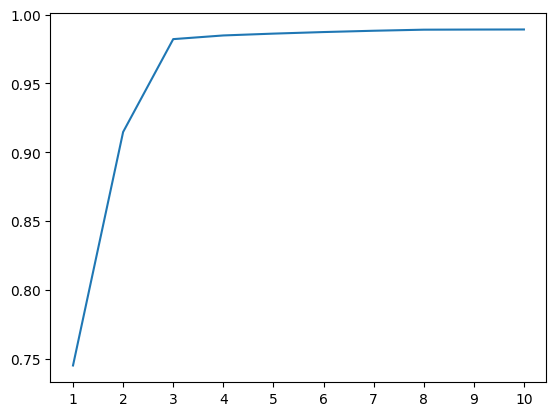

In [ ]:
pca_trigram = PCA(n_components = X_train_trigram.shape[1])
X_train_trigram_pca = pca_trigram.fit_transform(X_train_trigram.toarray())
explained_variance_score = pca_trigram.explained_variance_ratio_
cumulative = np.cumsum(explained_variance_score)
plt.plot(np.arange(1,11), cumulative[:10])
plt.xticks(np.arange(1,11))

In [ ]:
pca_trigram = PCA(n_components = 2)
X_train_trigram_pca = pca_trigram.fit_transform(X_train_trigram.toarray())
X_test_trigram_pca = pca_trigram.transform(X_test_trigram)

KeyboardInterrupt: 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda_trigram = LDA(n_components = 1)
X_train_lda = lda_trigram.fit_transform(X_train_trigram.toarray(), y_train_trigram)
X_test_lda = lda_trigram.transform(X_test_trigram.toarray())

NameError: name 'X_train_trigram' is not defined

In [ ]:
log_reg3 = LogisticRegression(random_state = 123, max_iter = 500, C = 0.1)

log_reg3.fit(X_train_trigram_pca, y_train_trigram)
cv_scores_trigram = cross_val_score(log_reg3, X_train_trigram_pca, y_train_trigram, cv=5, scoring='precision')

y_pred_trigram = log_reg3.predict(X_test_trigram_pca)

print(f'Train score: {np.mean(cv_scores_trigram)}')
print(f'Test score: {precision_score(y_test_trigram, y_pred_trigram)}')

Train score: 0.6210561831308157
Test score: 0.6184218606079214


In [ ]:
y_pred_proba_trigram = log_reg3.predict_proba(X_test_trigram_pca)
auc_score_trigram = average_precision_score(y_test_trigram, y_pred_proba_trigram[:,1])
precision_trigram, recall_trigram, _ = precision_recall_curve(y_test_trigram, y_pred_proba_trigram[:,1])

Regular AUC: 0.7180914635046749
Bigram AUC: 0.6233359207268053
Trigram AUC: 0.6233359207268053


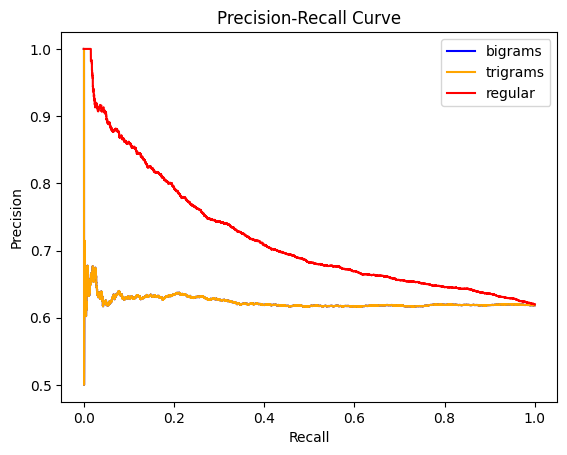

In [ ]:
plt.plot(recall_bigram, precision_bigram, color = 'blue', label = 'bigrams')
plt.plot(recall_trigram, precision_trigram, color = 'orange', label = 'trigrams')
plt.plot(recall, precision, color = 'red', label = 'regular')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

print(f'Regular AUC: {auc_score}')
print(f'Bigram AUC: {auc_score_bigram}')
print(f'Trigram AUC: {auc_score_trigram}')

## Miscellaneous

In [ ]:
#Auto correct
# spell = Speller(lang="en")
# comments["comment"] = comments["comment"].apply(lambda x: spell(x))
# comments.head()

In [ ]:
#TfidfVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

# v = TfidfVectorizer()
# corpus = comments["comment"]
# transformed = v.fit_transform(corpus)
# transformed.shape

In [ ]:
stopwords

#Remove stop words
def remove_stopwords(words):
  final = []
  for word in words:
    if word not in stopwords:
      final.append(word)
  return " ".join(final)

comments["comment"] = comments["comment"].apply(lambda x: remove_stopwords(x.split()))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: remove_stopwords(x.split()))

#Removing special characters and punctuation

comments["comment"] = comments["comment"].apply(lambda x: re.sub(r'[^\w ]+', "", x))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: re.sub(r'[^\w ]+', "", x))


#Frequency of words
text = " ".join(comments["comment"])
parent_text = " ".join(comments["parent_comment"])
text = text.split()
parent_text = parent_text.split()
word_freq = pd.Series(text).value_counts()
parent_freq = pd.Series(parent_text).value_counts()

#Get top20 words
top_20_words = word_freq[:20]
top_20_words_parent = parent_freq[:20]

#get rare words
#rare_words = word_freq.tail(17311) #words that are used once
rare_words = word_freq[word_freq == 1]
rare_words_parent = parent_freq[parent_freq == 1]

#Remove common words and rare words
comments["comment"] = comments["comment"].apply(lambda x: " ".join([t for t in x.split() if t not in rare_words]))
comments["comment"] = comments["comment"].apply(lambda x: " ".join([t for t in x.split() if t not in top_20_words]))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: " ".join([t for t in x.split() if t not in rare_words_parent]))
comments["parent_comment"] = comments["parent_comment"].apply(lambda x: " ".join([t for t in x.split() if t not in top_20_words_parent]))
comments.head()